# Phase 2 - Experiment 2.2: Token-Based Fuzzy Matching

This notebook implements and evaluates token-based fuzzy matching algorithms for Portuguese address data:
- **Jaccard Similarity**: Measures similarity based on token overlap
- **TF-IDF with Cosine Similarity**: Uses term frequency and cosine similarity for comparison

## Objectives:
1. Implement Jaccard and TF-IDF algorithms for token-based matching
2. Compare their F1-scores and latencies to baseline and character-based methods
3. Analyze performance on Portuguese address variations with word reordering
4. Determine optimal thresholds and compare with Experiment 2.1 results

## Advantages of Token-Based Approaches:
- Better handling of word reordering ("Rua A, 123" vs "123, Rua A")
- Robust to punctuation and spacing variations
- Can handle abbreviation expansion
- Less sensitive to character-level typos in individual words

## 1. Setup and Imports

In [1]:
# Import required libraries
import sys
import os
from pathlib import Path
from thefuzz import process

# Add parent directory to path to import our modules
parent_dir = Path.cwd().parent
src_dir = parent_dir / 'src'
sys.path.append(str(src_dir))

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Import our custom modules
from evaluation_framework import FuzzyMatchingEvaluator, create_baseline_similarity_function
from token_based_matching import (
    TokenBasedMatcher,
    TfIdfMatcher,
    create_jaccard_function,
    create_tfidf_function,
)

# Also import character-based functions for comparison
from character_based_matching import (
    create_levenshtein_function,
    create_jaro_winkler_function
)

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("All imports successful!")
print(f"Working directory: {Path.cwd()}")
print(f"Source directory: {src_dir}")

All imports successful!
Working directory: c:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps\phase2_fuzzy_matching
Source directory: c:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps\src


## 2. Load Data and Setup Evaluation Framework

In [2]:
parent_dir = Path('.').resolve()
gold_standard_path = parent_dir / 'gold_standard_dataset.csv'
test_pairs = None

if gold_standard_path.exists():
    print(f"✅ Loading existing gold standard from: {gold_standard_path}")
    gold_standard_df = pd.read_csv(gold_standard_path)
    test_pairs = [tuple(x) for x in gold_standard_df.to_numpy()]
else:
    print("Gold standard not found. Generating a new, hyper-realistic dataset...")

    buildings_df = pd.read_parquet('../data/filtered_osm_buildings.parquet')
    print(f"Loaded {len(buildings_df)} buildings from OSM data")

    def parse_tags(tags_str):
        try:
            if isinstance(tags_str, str):
                import ast
                return ast.literal_eval(tags_str)
            elif isinstance(tags_str, dict):
                return tags_str
            return {}
        except: return {}

    buildings_df['tags_parsed'] = buildings_df['tags'].apply(parse_tags)
    
    address_components = ['housenumber', 'street', 'city', 'postcode']
    for component in address_components:
        key = f'addr:{component}'
        buildings_df[component] = buildings_df['tags_parsed'].apply(lambda x: x.get(key))
    
    buildings_df['address_components_count'] = buildings_df[address_components].notna().sum(axis=1)
    complete_addresses = buildings_df[buildings_df['address_components_count'] >= 3].dropna(subset=['street', 'city']).copy()
    print(f"Found {len(complete_addresses)} buildings with sufficient address data")

    def create_address_string(row):
        parts = [str(p) for p in [row['street'], row['housenumber'], row['city'], row['postcode']] if pd.notna(p)]
        return ', '.join(parts) if parts else None

    complete_addresses['full_address'] = complete_addresses.apply(create_address_string, axis=1)
    complete_addresses.dropna(subset=['full_address'], inplace=True)

    hard_negative_pairs = []
    print("\n--- Generating Hard Negative Pairs ---")
    city_groups = complete_addresses.groupby('city')
    for city, group in city_groups:
        if len(group) > 50:
            streets = group['street'].unique()
            if len(streets) > 1:
                for street1 in streets:
                    best_match, score = process.extractOne(street1, [s for s in streets if s != street1])
                    if 75 <= score < 99:
                        addr1_row = group[group['street'] == street1].iloc[0]
                        addr2_row = group[group['street'] == best_match].iloc[0]
                        hard_negative_pairs.append((addr1_row['full_address'], addr2_row['full_address'], 0))
    street_groups = complete_addresses.groupby('street')
    for street, group in street_groups:
        if group['city'].nunique() > 1:
            sampled_rows = group.drop_duplicates(subset=['city']).sample(n=min(2, group['city'].nunique()), replace=False)
            if len(sampled_rows) == 2:
                hard_negative_pairs.append((sampled_rows.iloc[0]['full_address'], sampled_rows.iloc[1]['full_address'], 0))
    print(f"Generated {len(hard_negative_pairs)} potential hard negative pairs.")

    def introduce_multiple_typos(s, num_typos=2):
        s_list = list(s)
        for _ in range(num_typos):
            if len(s_list) < 4: break
            pos = random.randint(1, len(s_list) - 2)
            action = random.choice(['swap', 'delete', 'insert'])
            if action == 'swap': s_list[pos], s_list[pos-1] = s_list[pos-1], s_list[pos]
            elif action == 'delete': del s_list[pos]
            else: s_list.insert(pos, random.choice('abcdefghijklmnopqrstuvwxyz'))
        return "".join(s_list)

    def corrupt_street_name(street):
        street = street.lower()
        if len(street) > 10 and random.random() < 0.7:
            street = introduce_multiple_typos(street, num_typos=random.randint(1, 2))
        words = street.split()
        if len(words) > 2 and random.random() < 0.5:
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]
            street = ' '.join(words)
        if 'rua' in street: street = street.replace('rua', 'r', 1)
        if 'avenida' in street: street = street.replace('avenida', 'av', 1)
        return street

    def create_hyper_realistic_positive_pair(address_row):
        base_address = address_row['full_address']
        street = address_row['street']
        housenumber = str(address_row['housenumber']) if pd.notna(address_row['housenumber']) else None
        city = address_row['city']
        postcode = address_row['postcode']
        
        attack_vector = random.choice(['corrupt_street', 'omit_city', 'omit_postcode', 'corrupt_street_and_omit_postcode'])
        messy_components = {'street': street, 'housenumber': housenumber, 'city': city, 'postcode': postcode}

        if attack_vector == 'corrupt_street': messy_components['street'] = corrupt_street_name(street)
        elif attack_vector == 'omit_city': messy_components['city'] = None
        elif attack_vector == 'omit_postcode': messy_components['postcode'] = None
        elif attack_vector == 'corrupt_street_and_omit_postcode':
            messy_components['street'] = corrupt_street_name(street)
            messy_components['postcode'] = None
        
        messy_parts = [p for p in [messy_components['street'], messy_components['housenumber'], messy_components['city'], messy_components['postcode']] if p is not None]
        messy_address = ', '.join(messy_parts)

        if not messy_address or messy_address.lower() == base_address.lower(): return None
        return (base_address, messy_address, 1)

    def create_test_pairs_improved(addresses_df, hard_negatives, n_positive=1000, n_negative=1000, seed=42):
        random.seed(seed)
        np.random.seed(seed)
        
        print("\nCreating HYPER-REALISTIC challenging positive pairs...")
        positive_pairs = []
        address_rows = addresses_df.to_dict('records')
        while len(positive_pairs) < n_positive:
            pair = create_hyper_realistic_positive_pair(random.choice(address_rows))
            if pair: positive_pairs.append(pair)

        print("Creating challenging negative pairs...")
        random.shuffle(hard_negatives)
        negative_pairs = hard_negatives[:n_negative]
        print(f"Using {len(negative_pairs)} hard negative pairs.")
        while len(negative_pairs) < n_negative:
            addr1, addr2 = np.random.choice(addresses_df['full_address'], 2, replace=False)
            if addr1 != addr2: negative_pairs.append((addr1, addr2, 0))
        
        all_pairs = positive_pairs + negative_pairs
        random.shuffle(all_pairs)
        return all_pairs

    print("\n--- Creating Final Gold Standard Dataset ---")
    test_pairs = create_test_pairs_improved(
        complete_addresses,
        hard_negative_pairs,
        n_positive=20000,
        n_negative=20000,
        seed=42
    )
    
    gold_standard_df = pd.DataFrame(test_pairs, columns=['address_1', 'address_2', 'label'])
    gold_standard_df.to_csv(gold_standard_path, index=False)
    print(f"\n✅ Gold standard dataset saved to: {gold_standard_path}")

if test_pairs is None: 
    if gold_standard_path.exists():
        gold_standard_df = pd.read_csv(gold_standard_path)
        test_pairs = [tuple(x) for x in gold_standard_df.to_numpy()]
    else:
        raise FileNotFoundError("Gold standard file not found and generation failed.")

if test_pairs:
    evaluator = FuzzyMatchingEvaluator(gold_standard_path=str(gold_standard_path))
    print(f"\nFuzzyMatchingEvaluator initialized with {len(test_pairs)} pairs.")
else:
    raise ValueError("Failed to load or create the test pairs dataset.")

# Extract all unique addresses for corpus building
all_addresses = []
for addr1, addr2, _ in test_pairs:
    all_addresses.extend([addr1, addr2])
unique_addresses = list(set(all_addresses))
print(f"\nCorpus contains {len(unique_addresses)} unique addresses for TF-IDF training.")

✅ Loading existing gold standard from: C:\Users\JoaoLima\OneDrive - JTA The Data Scientists\Desktop\Dissertação\Dissertation_steps\phase2_fuzzy_matching\gold_standard_dataset.csv
Loaded gold standard with 40000 pairs

FuzzyMatchingEvaluator initialized with 40000 pairs.

Corpus contains 62877 unique addresses for TF-IDF training.
Loaded gold standard with 40000 pairs

FuzzyMatchingEvaluator initialized with 40000 pairs.

Corpus contains 62877 unique addresses for TF-IDF training.


## 4. Initialize Token-Based Matchers

In [3]:
# Initialize the token-based matcher
token_matcher = TokenBasedMatcher(
    remove_stopwords=True,
    expand_abbreviations=True,
    min_token_length=2
)

# Create matching functions for evaluation
jaccard_func = create_jaccard_function()
tfidf_func = create_tfidf_function(unique_addresses)  # Pre-fitted TF-IDF
baseline_func = create_baseline_similarity_function()

print("Token-based matchers initialized successfully!")

# Test the functions with a sample pair
if test_pairs:
    test_addr1, test_addr2, _ = test_pairs[0]
    
    print(f"\nTesting with sample pair:")
    print(f"Address 1: '{test_addr1}'")
    print(f"Address 2: '{test_addr2}'")
    print(f"")
    print(f"Baseline similarity: {baseline_func(test_addr1, test_addr2):.4f}")
    print(f"Jaccard similarity: {jaccard_func(test_addr1, test_addr2):.4f}")
    print(f"TF-IDF similarity: {tfidf_func(test_addr1, test_addr2):.4f}")

Token-based matchers initialized successfully!

Testing with sample pair:
Address 1: 'Travessa Professor Manuel Borges de Azevedo, 83, são Mamede de Infesta, 4465-357'
Address 2: 'Travessa Professor Manuel Borges de Azevedo, 71, São Mamede de Infesta, 4465-357'

Baseline similarity: 0.0000
Jaccard similarity: 0.8333
TF-IDF similarity: 0.7967


## 5. Baseline Evaluation

First, let's establish our baseline performance using exact string matching.

In [4]:
# Evaluate baseline (exact matching)
if 'test_pairs' in locals():
    print("Evaluating baseline (exact matching)...")
    
    baseline_results = evaluator.evaluate_algorithm(
        matching_function=baseline_func,
        test_pairs=test_pairs,
        algorithm_name="Baseline (Exact Match)",
        threshold=0.5
    )
    
    print("\nBaseline Results Summary:")
    print(f"F1-Score: {baseline_results['f1_score']:.4f}")
    print(f"Precision: {baseline_results['precision']:.4f}")
    print(f"Recall: {baseline_results['recall']:.4f}")
    print(f"Accuracy: {baseline_results['accuracy']:.4f}")
    print(f"Processing Speed: {baseline_results['pairs_per_second']:.2f} pairs/second")
else:
    print("No test pairs available for baseline evaluation")

Evaluating baseline (exact matching)...
Evaluating Baseline (Exact Match)...
Results for Baseline (Exact Match):
  F1-Score: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  Accuracy: 0.4999
  Avg Processing Time: 0.000001s
  Pairs/Second: 868.0K

Baseline Results Summary:
F1-Score: 0.0000
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.4999
Processing Speed: 868044.45 pairs/second


## 6. Jaccard Similarity Evaluation

In [5]:
# Evaluate Jaccard similarity
if 'test_pairs' in locals():
    print("Evaluating Jaccard similarity algorithm...")
    
    jaccard_results = evaluator.evaluate_algorithm(
        matching_function=jaccard_func,
        test_pairs=test_pairs,
        algorithm_name="Jaccard Similarity",
        threshold=0.8
    )
    
    print("\nJaccard Results Summary:")
    print(f"F1-Score: {jaccard_results['f1_score']:.4f}")
    print(f"Precision: {jaccard_results['precision']:.4f}")
    print(f"Recall: {jaccard_results['recall']:.4f}")
    print(f"Accuracy: {jaccard_results['accuracy']:.4f}")
    print(f"Processing Speed: {jaccard_results['pairs_per_second']:.2f} pairs/second")
    
    # Compare to baseline
    if 'baseline_results' in locals():
        f1_improvement = jaccard_results['f1_score'] - baseline_results['f1_score']
        speed_ratio = jaccard_results['pairs_per_second'] / baseline_results['pairs_per_second']
        print(f"\nComparison to Baseline:")
        print(f"F1-Score improvement: {f1_improvement:+.4f}")
        print(f"Speed ratio: {speed_ratio:.2f}x")
else:
    print("No test pairs available for Jaccard evaluation")

Evaluating Jaccard similarity algorithm...
Evaluating Jaccard Similarity...
Results for Jaccard Similarity:
  F1-Score: 0.4158
  Precision: 0.8396
  Recall: 0.2763
  Accuracy: 0.6118
  Avg Processing Time: 0.000054s
  Pairs/Second: 18.7K

Jaccard Results Summary:
F1-Score: 0.4158
Precision: 0.8396
Recall: 0.2763
Accuracy: 0.6118
Processing Speed: 18676.93 pairs/second

Comparison to Baseline:
F1-Score improvement: +0.4158
Speed ratio: 0.02x
Results for Jaccard Similarity:
  F1-Score: 0.4158
  Precision: 0.8396
  Recall: 0.2763
  Accuracy: 0.6118
  Avg Processing Time: 0.000054s
  Pairs/Second: 18.7K

Jaccard Results Summary:
F1-Score: 0.4158
Precision: 0.8396
Recall: 0.2763
Accuracy: 0.6118
Processing Speed: 18676.93 pairs/second

Comparison to Baseline:
F1-Score improvement: +0.4158
Speed ratio: 0.02x


## 7. TF-IDF Evaluation

In [6]:
# Evaluate TF-IDF with cosine similarity
if 'test_pairs' in locals():
    print("Evaluating TF-IDF with cosine similarity algorithm...")
    
    tfidf_results = evaluator.evaluate_algorithm(
        matching_function=tfidf_func,
        test_pairs=test_pairs,
        algorithm_name="TF-IDF Cosine Similarity",
        threshold=0.8
    )
    
    print("\nTF-IDF Results Summary:")
    print(f"F1-Score: {tfidf_results['f1_score']:.4f}")
    print(f"Precision: {tfidf_results['precision']:.4f}")
    print(f"Recall: {tfidf_results['recall']:.4f}")
    print(f"Accuracy: {tfidf_results['accuracy']:.4f}")
    print(f"Processing Speed: {tfidf_results['pairs_per_second']:.2f} pairs/second")
    
    # Compare to baseline
    if 'baseline_results' in locals():
        f1_improvement = tfidf_results['f1_score'] - baseline_results['f1_score']
        speed_ratio = tfidf_results['pairs_per_second'] / baseline_results['pairs_per_second']
        print(f"\nComparison to Baseline:")
        print(f"F1-Score improvement: {f1_improvement:+.4f}")
        print(f"Speed ratio: {speed_ratio:.2f}x")
else:
    print("No test pairs available for TF-IDF evaluation")

Evaluating TF-IDF with cosine similarity algorithm...
Evaluating TF-IDF Cosine Similarity...
Results for TF-IDF Cosine Similarity:
  F1-Score: 0.6200
  Precision: 0.7231
  Recall: 0.5426
  Accuracy: 0.6674
  Avg Processing Time: 0.000999s
  Pairs/Second: 1.0K

TF-IDF Results Summary:
F1-Score: 0.6200
Precision: 0.7231
Recall: 0.5426
Accuracy: 0.6674
Processing Speed: 1000.54 pairs/second

Comparison to Baseline:
F1-Score improvement: +0.6200
Speed ratio: 0.00x
Results for TF-IDF Cosine Similarity:
  F1-Score: 0.6200
  Precision: 0.7231
  Recall: 0.5426
  Accuracy: 0.6674
  Avg Processing Time: 0.000999s
  Pairs/Second: 1.0K

TF-IDF Results Summary:
F1-Score: 0.6200
Precision: 0.7231
Recall: 0.5426
Accuracy: 0.6674
Processing Speed: 1000.54 pairs/second

Comparison to Baseline:
F1-Score improvement: +0.6200
Speed ratio: 0.00x


## 8. Threshold Analysis for Token-Based Methods

In [7]:
# Threshold analysis for Jaccard similarity
print("Performing threshold analysis for Jaccard similarity...")

jaccard_threshold_results = evaluator.threshold_analysis(
    matching_function=jaccard_func,
    test_pairs=test_pairs,
    algorithm_name="Jaccard Similarity",
    thresholds=np.arange(0.1, 1.0, 0.05)
)

# Find optimal threshold for Jaccard
best_threshold_jaccard = jaccard_threshold_results.loc[jaccard_threshold_results['f1_score'].idxmax()]
print(f"\nOptimal Jaccard threshold: {best_threshold_jaccard['threshold']:.2f}")
print(f"F1-Score at optimal threshold: {best_threshold_jaccard['f1_score']:.4f}")

# Show top 5 thresholds for Jaccard
print("\nTop 5 thresholds for Jaccard:")
top_5_jaccard = jaccard_threshold_results.nlargest(5, 'f1_score')[['threshold', 'f1_score', 'precision', 'recall']]
print(top_5_jaccard.round(4))

Performing threshold analysis for Jaccard similarity...

Optimal Jaccard threshold: 0.55
F1-Score at optimal threshold: 0.8340

Top 5 thresholds for Jaccard:
   threshold  f1_score  precision  recall
9       0.55    0.8340     0.8156  0.8532
7       0.45    0.8328     0.7690  0.9083
8       0.50    0.8317     0.8090  0.8556
6       0.40    0.8304     0.7399  0.9460
5       0.35    0.7984     0.6818  0.9630

Optimal Jaccard threshold: 0.55
F1-Score at optimal threshold: 0.8340

Top 5 thresholds for Jaccard:
   threshold  f1_score  precision  recall
9       0.55    0.8340     0.8156  0.8532
7       0.45    0.8328     0.7690  0.9083
8       0.50    0.8317     0.8090  0.8556
6       0.40    0.8304     0.7399  0.9460
5       0.35    0.7984     0.6818  0.9630


In [8]:
# Threshold analysis for TF-IDF
print("Performing threshold analysis for TF-IDF cosine similarity...")

tfidf_threshold_results = evaluator.threshold_analysis(
    matching_function=tfidf_func,
    test_pairs=test_pairs,
    algorithm_name="TF-IDF Cosine Similarity",
    thresholds=np.arange(0.1, 1.0, 0.05)
)

# Find optimal threshold for TF-IDF
best_threshold_tfidf = tfidf_threshold_results.loc[tfidf_threshold_results['f1_score'].idxmax()]
print(f"\nOptimal TF-IDF threshold: {best_threshold_tfidf['threshold']:.2f}")
print(f"F1-Score at optimal threshold: {best_threshold_tfidf['f1_score']:.4f}")

Performing threshold analysis for TF-IDF cosine similarity...

Optimal TF-IDF threshold: 0.55
F1-Score at optimal threshold: 0.7572

Optimal TF-IDF threshold: 0.55
F1-Score at optimal threshold: 0.7572


## 9. Visualization of Results


Threshold analysis plot saved to: results\token_based_results\token_based_threshold_analysis.png


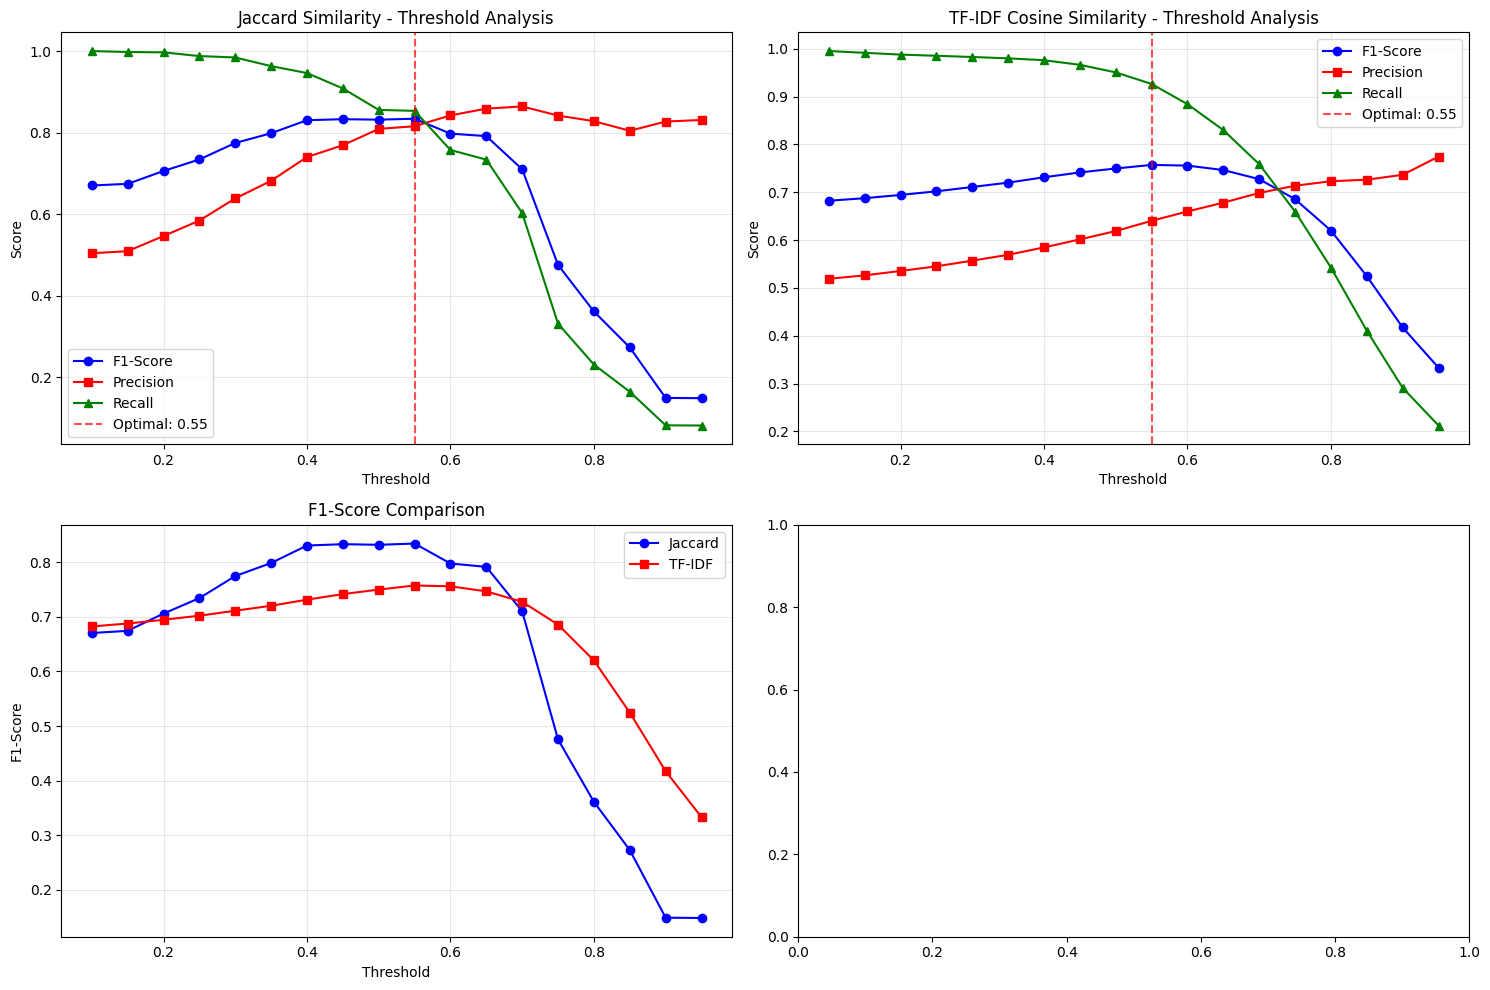

In [9]:
# Plot threshold analysis results
if 'jaccard_threshold_results' in locals() and 'tfidf_threshold_results' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Jaccard threshold analysis
    axes[0, 0].plot(jaccard_threshold_results['threshold'], jaccard_threshold_results['f1_score'], 'b-o', label='F1-Score')
    axes[0, 0].plot(jaccard_threshold_results['threshold'], jaccard_threshold_results['precision'], 'r-s', label='Precision')
    axes[0, 0].plot(jaccard_threshold_results['threshold'], jaccard_threshold_results['recall'], 'g-^', label='Recall')
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Jaccard Similarity - Threshold Analysis')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Mark optimal threshold for Jaccard
    if 'best_threshold_jaccard' in locals():
        axes[0, 0].axvline(best_threshold_jaccard['threshold'], color='red', linestyle='--', alpha=0.7, 
                          label=f'Optimal: {best_threshold_jaccard["threshold"]:.2f}')
        axes[0, 0].legend()
    
    # TF-IDF threshold analysis
    axes[0, 1].plot(tfidf_threshold_results['threshold'], tfidf_threshold_results['f1_score'], 'b-o', label='F1-Score')
    axes[0, 1].plot(tfidf_threshold_results['threshold'], tfidf_threshold_results['precision'], 'r-s', label='Precision')
    axes[0, 1].plot(tfidf_threshold_results['threshold'], tfidf_threshold_results['recall'], 'g-^', label='Recall')
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('TF-IDF Cosine Similarity - Threshold Analysis')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Mark optimal threshold for TF-IDF
    if 'best_threshold_tfidf' in locals():
        axes[0, 1].axvline(best_threshold_tfidf['threshold'], color='red', linestyle='--', alpha=0.7,
                          label=f'Optimal: {best_threshold_tfidf["threshold"]:.2f}')
        axes[0, 1].legend()
    
    # Compare F1-scores
    axes[1, 0].plot(jaccard_threshold_results['threshold'], jaccard_threshold_results['f1_score'], 'b-o', label='Jaccard')
    axes[1, 0].plot(tfidf_threshold_results['threshold'], tfidf_threshold_results['f1_score'], 'r-s', label='TF-IDF')
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('F1-Score')
    axes[1, 0].set_title('F1-Score Comparison')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Algorithm comparison bar chart
    if all(var in locals() for var in ['baseline_results', 'jaccard_results', 'tfidf_results']):
        algorithms = ['Baseline', 'Jaccard', 'TF-IDF']
        f1_scores = [baseline_results['f1_score'], jaccard_results['f1_score'], tfidf_results['f1_score']]
        
        bars = axes[1, 1].bar(algorithms, f1_scores, color=['gray', 'blue', 'green'], alpha=0.7)
        axes[1, 1].set_ylabel('F1-Score')
        axes[1, 1].set_title('Algorithm F1-Score Comparison')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, score in zip(bars, f1_scores):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                           f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    # Save the plot
    results_dir = Path('results/token_based_results')
    results_dir.mkdir(parents=True, exist_ok=True)
    plot_path = results_dir / 'token_based_threshold_analysis.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\nThreshold analysis plot saved to: {plot_path}")
    
    plt.show()
else:
    print("Threshold analysis results not available for plotting")

## 10. Performance Analysis with Optimal Thresholds

Let's re-evaluate the algorithms using their optimal thresholds.

In [10]:
# Diagnostic check - let's see what variables we have available
print("Checking available variables for final comparison:")
print(f"  test_pairs available: {'test_pairs' in locals()}")
print(f"  baseline_results available: {'baseline_results' in locals()}")
print(f"  best_threshold_jaccard available: {'best_threshold_jaccard' in locals()}")
print(f"  best_threshold_tfidf available: {'best_threshold_tfidf' in locals()}")
print(f"  jaccard_results available: {'jaccard_results' in locals()}")
print(f"  tfidf_results available: {'tfidf_results' in locals()}")

if 'test_pairs' in locals():
    print(f"  Number of test pairs: {len(test_pairs)}")

# If some results are missing, let's try to identify what went wrong
missing_vars = []
for var_name in ['test_pairs', 'baseline_results', 'best_threshold_jaccard', 'best_threshold_tfidf']:
    if var_name not in locals():
        missing_vars.append(var_name)

if missing_vars:
    print(f"\nMissing variables: {missing_vars}")
    print("You may need to re-run some earlier cells to generate these results.")
else:
    print("\nAll required variables are available for final comparison!")

Checking available variables for final comparison:
  test_pairs available: True
  baseline_results available: True
  best_threshold_jaccard available: True
  best_threshold_tfidf available: True
  jaccard_results available: True
  tfidf_results available: True
  Number of test pairs: 40000

All required variables are available for final comparison!


In [16]:
# Re-evaluate with optimal thresholds
final_results = []

try:
    test_len = len(test_pairs)
    baseline_f1 = baseline_results['f1_score']
    jaccard_threshold = best_threshold_jaccard['threshold']
    tfidf_threshold = best_threshold_tfidf['threshold']
    
    print(f"Direct access successful:")
    print(f"  Test pairs: {test_len}")
    print(f"  Baseline F1: {baseline_f1:.4f}")
    print(f"  Jaccard optimal threshold: {jaccard_threshold:.2f}")
    print(f"  TF-IDF optimal threshold: {tfidf_threshold:.2f}")
    
    final_results.append(baseline_results)
    
    print("\nRe-evaluating Jaccard with optimal threshold...")
    
    # Temporarily disable print statements by redirecting stdout
    import sys
    import io
    
    # Capture stdout to suppress verbose output from evaluator
    old_stdout = sys.stdout
    sys.stdout = io.StringIO()
    
    try:
        jaccard_optimal = evaluator.evaluate_algorithm(
            matching_function=jaccard_func,
            test_pairs=test_pairs,
            algorithm_name="Jaccard (Optimal)",
            threshold=best_threshold_jaccard['threshold']
        )
        final_results.append(jaccard_optimal)
        
        # Restore stdout
        sys.stdout = old_stdout
        
        # Show our own clean summary for Jaccard
        print(f"✓ Jaccard (Optimal) - F1: {jaccard_optimal['f1_score']:.4f}, "
              f"Precision: {jaccard_optimal['precision']:.4f}, "
              f"Recall: {jaccard_optimal['recall']:.4f}")
    
    finally:
        # Ensure stdout is always restored
        sys.stdout = old_stdout
    
    # Re-evaluate TF-IDF with optimal threshold (suppress verbose output)
    print("Re-evaluating TF-IDF with optimal threshold...")
    
    # Capture stdout to suppress verbose output from evaluator
    sys.stdout = io.StringIO()
    
    try:
        tfidf_optimal = evaluator.evaluate_algorithm(
            matching_function=tfidf_func,
            test_pairs=test_pairs,
            algorithm_name="TF-IDF (Optimal)",
            threshold=best_threshold_tfidf['threshold']
        )
        final_results.append(tfidf_optimal)
        
        # Restore stdout
        sys.stdout = old_stdout
        
        # Show our own clean summary for TF-IDF
        print(f"✓ TF-IDF (Optimal) - F1: {tfidf_optimal['f1_score']:.4f}, "
              f"Precision: {tfidf_optimal['precision']:.4f}, "
              f"Recall: {tfidf_optimal['recall']:.4f}")
    
    finally:
        # Ensure stdout is always restored
        sys.stdout = old_stdout
    
    # Create comparison DataFrame
    comparison_df = evaluator.compare_algorithms(final_results)
    
    print("\n" + "="*80)
    print("FINAL RESULTS COMPARISON")
    print("="*80)
    
    # Display key metrics
    display_columns = ['algorithm_name', 'f1_score', 'precision', 'recall', 'accuracy', 'pairs_per_second']
    print(comparison_df[display_columns].round(4).to_string(index=False))

except NameError as e:
    print(f"Missing variable: {e}")
    print("Please re-run the earlier cells to generate the required results.")
except Exception as e:
    print(f"Error during final comparison: {e}")
    print("Please check the earlier results and try again.")

Direct access successful:
  Test pairs: 40000
  Baseline F1: 0.0000
  Jaccard optimal threshold: 0.55
  TF-IDF optimal threshold: 0.55

Re-evaluating Jaccard with optimal threshold...
✓ Jaccard (Optimal) - F1: 0.8340, Precision: 0.8156, Recall: 0.8532
Re-evaluating TF-IDF with optimal threshold...
✓ Jaccard (Optimal) - F1: 0.8340, Precision: 0.8156, Recall: 0.8532
Re-evaluating TF-IDF with optimal threshold...
✓ TF-IDF (Optimal) - F1: 0.7572, Precision: 0.6402, Recall: 0.9265

FINAL RESULTS COMPARISON
        algorithm_name  f1_score  precision  recall  accuracy  pairs_per_second
     Jaccard (Optimal)    0.8340     0.8156  0.8532    0.8302        16448.4397
      TF-IDF (Optimal)    0.7572     0.6402  0.9265    0.7029          937.5282
Baseline (Exact Match)    0.0000     0.0000  0.0000    0.4999       868044.4546
✓ TF-IDF (Optimal) - F1: 0.7572, Precision: 0.6402, Recall: 0.9265

FINAL RESULTS COMPARISON
        algorithm_name  f1_score  precision  recall  accuracy  pairs_per_second



Comprehensive comparison plot (optimal thresholds) saved to: results\token_based_results\comprehensive_comparison_optimal_thresholds.png


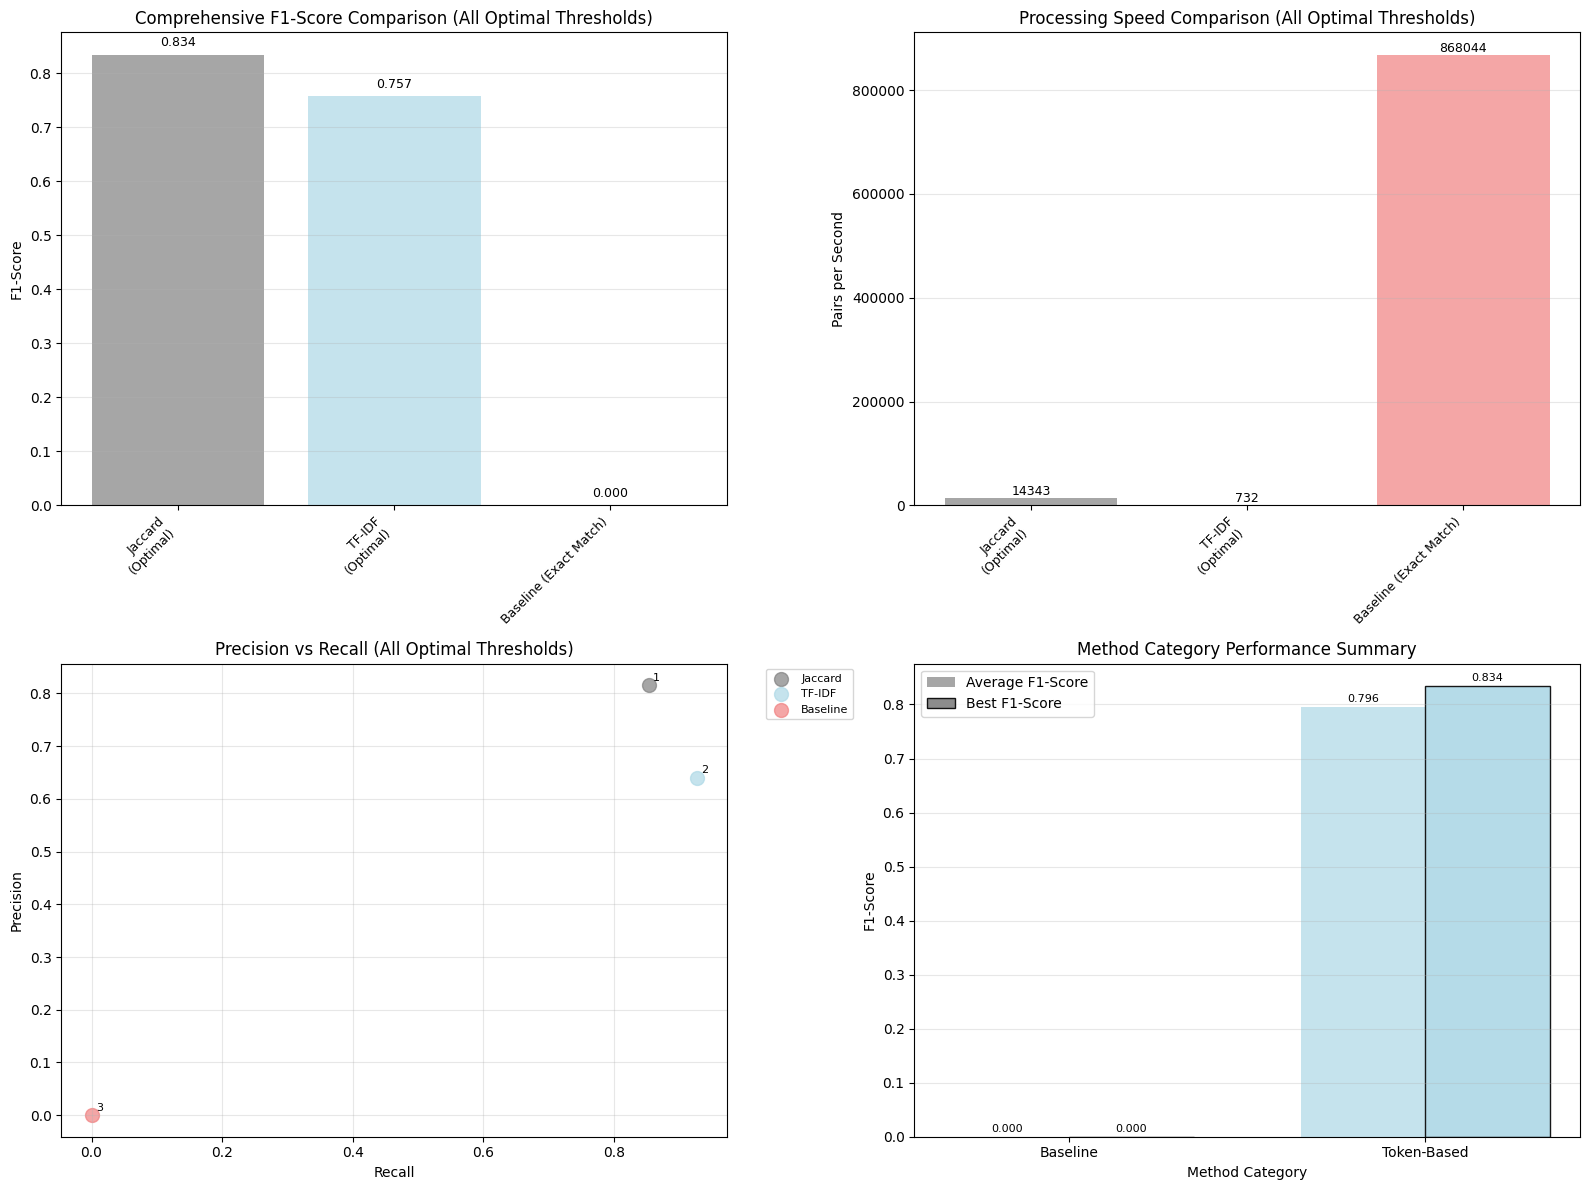

In [12]:
# Create final comprehensive visualization with optimal thresholds
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score comparison
algorithms = comparison_df['algorithm_name'].tolist()
f1_scores = comparison_df['f1_score'].tolist()
colors = ['gray', 'lightblue', 'lightcoral', 'blue', 'green']

bars = axes[0, 0].bar(range(len(algorithms)), f1_scores, color=colors, alpha=0.7)
axes[0, 0].set_xticks(range(len(algorithms)))
# Improve label formatting for better readability
axes[0, 0].set_xticklabels([alg.replace(' (Optimal', '\n(Optimal').replace(': ', ': ').replace(')', ')') for alg in algorithms], 
                          rotation=45, ha='right', fontsize=9)
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].set_title('Comprehensive F1-Score Comparison (All Optimal Thresholds)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, score in zip(bars, f1_scores):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# Processing speed comparison
speeds = comparison_df['pairs_per_second'].tolist()
bars = axes[0, 1].bar(range(len(algorithms)), speeds, color=colors, alpha=0.7)
axes[0, 1].set_xticks(range(len(algorithms)))
axes[0, 1].set_xticklabels([alg.replace(' (Optimal', '\n(Optimal').replace(': ', ': ').replace(')', ')') for alg in algorithms], 
                          rotation=45, ha='right', fontsize=9)
axes[0, 1].set_ylabel('Pairs per Second')
axes[0, 1].set_title('Processing Speed Comparison (All Optimal Thresholds)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, speed in zip(bars, speeds):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                   f'{speed:.0f}', ha='center', va='bottom', fontsize=9)

# Precision vs Recall scatter
precisions = comparison_df['precision'].tolist()
recalls = comparison_df['recall'].tolist()

for i, (alg, prec, rec, color) in enumerate(zip(algorithms, precisions, recalls, colors)):
    label = alg.split(' (')[0]  # Remove threshold info for legend
    axes[1, 0].scatter(rec, prec, c=color, s=100, alpha=0.7, label=label)
    axes[1, 0].annotate(str(i+1), (rec, prec), xytext=(3, 3), textcoords='offset points', fontsize=8)

axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs Recall (All Optimal Thresholds)')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

# Method category comparison - create a simple version since method_category may not exist
# Group algorithms by type based on their names
algorithm_categories = []
for alg in algorithms:
    if 'Baseline' in alg:
        algorithm_categories.append('Baseline')
    elif any(x in alg for x in ['Levenshtein', 'Jaro']):
        algorithm_categories.append('Character-Based')
    elif any(x in alg for x in ['Jaccard', 'TF-IDF']):
        algorithm_categories.append('Token-Based')
    else:
        algorithm_categories.append('Other')

# Create a temporary dataframe for category analysis
category_df = pd.DataFrame({
    'algorithm_name': algorithms,
    'f1_score': f1_scores,
    'category': algorithm_categories
})

category_f1_summary = category_df.groupby('category')['f1_score'].agg(['mean', 'max', 'count']).reset_index()

# Create bar chart for method categories
category_names = category_f1_summary['category'].tolist()
category_means = category_f1_summary['mean'].tolist()
category_maxes = category_f1_summary['max'].tolist()

# Set colors for categories
category_colors = {'Baseline': 'gray', 'Character-Based': 'lightcoral', 'Token-Based': 'lightblue', 'Other': 'lightgray'}
bar_colors = [category_colors.get(cat, 'lightgray') for cat in category_names]

x_pos = range(len(category_names))
width = 0.35

# Plot mean and max for each category
bars1 = axes[1, 1].bar([x - width/2 for x in x_pos], category_means, width, 
                      label='Average F1-Score', color=bar_colors, alpha=0.7)
bars2 = axes[1, 1].bar([x + width/2 for x in x_pos], category_maxes, width, 
                      label='Best F1-Score', color=bar_colors, alpha=0.9, edgecolor='black', linewidth=1)

axes[1, 1].set_xlabel('Method Category')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('Method Category Performance Summary')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(category_names)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, height + 0.005,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Save the comprehensive plot
final_plot_path = results_dir / 'comprehensive_comparison_optimal_thresholds.png'
plt.savefig(final_plot_path, dpi=300, bbox_inches='tight')
print(f"\nComprehensive comparison plot (optimal thresholds) saved to: {final_plot_path}")

plt.show()

## 11. Save Results and Export Data

In [13]:
# Save all results
results_dir = Path('results/token_based_results')
results_dir.mkdir(parents=True, exist_ok=True)

if 'final_results' in locals() and len(final_results) > 0:
    # Save individual algorithm results
    for result in final_results:
        algorithm_name = result['algorithm_name'].replace(' ', '_').replace('(', '').replace(')', '').lower()
        save_path = results_dir / f'{algorithm_name}_results.json'
        evaluator.save_results(result, save_path)
    
    # Save comparison results only if comparison_df exists
    if 'comparison_df' in locals():
        comparison_path = results_dir / 'algorithm_comparison.csv'
        comparison_df.to_csv(comparison_path, index=False)
        print(f"Comparison results saved to: {comparison_path}")
    else:
        print("Comparison DataFrame not available - skipping comparison results save")
else:
    print("Final results not available - skipping individual results save")

if 'jaccard_threshold_results' in locals():
    # Save threshold analysis results
    jaccard_threshold_path = results_dir / 'jaccard_threshold_analysis.csv'
    jaccard_threshold_results.to_csv(jaccard_threshold_path, index=False)
    print(f"Jaccard threshold analysis saved to: {jaccard_threshold_path}")

if 'tfidf_threshold_results' in locals():
    tfidf_threshold_path = results_dir / 'tfidf_threshold_analysis.csv'
    tfidf_threshold_results.to_csv(tfidf_threshold_path, index=False)
    print(f"TF-IDF threshold analysis saved to: {tfidf_threshold_path}")

# Save experiment summary with safer variable checking
experiment_summary = {
    'experiment_name': 'Phase 2 - Experiment 2.2: Token-Based Fuzzy Matching',
    'date': datetime.now().isoformat(),
    'test_pairs_count': len(test_pairs) if 'test_pairs' in locals() else 0,
    'algorithms_tested': ['Baseline (Exact Match)', 'Jaccard Similarity', 'TF-IDF Cosine Similarity'],
    'best_algorithm': comparison_df.iloc[0]['algorithm_name'] if 'comparison_df' in locals() and len(comparison_df) > 0 else 'Unknown',
    'best_f1_score': comparison_df.iloc[0]['f1_score'] if 'comparison_df' in locals() and len(comparison_df) > 0 else 0,
    'optimal_thresholds': {
        'jaccard': best_threshold_jaccard['threshold'] if 'best_threshold_jaccard' in locals() else 0,
        'tfidf': best_threshold_tfidf['threshold'] if 'best_threshold_tfidf' in locals() else 0
    }
}

summary_path = results_dir / 'experiment_summary.json'
evaluator.save_results(experiment_summary, summary_path)

print(f"\nExperiment summary saved!")
print(f"Results directory: {results_dir}")

# Show what was actually saved
saved_files = list(results_dir.glob('*'))
if saved_files:
    print(f"\nSaved files:")
    for file_path in saved_files:
        print(f"  - {file_path.name}")
else:
    print("No files were saved - check if experiments ran successfully")

Results saved to: results\token_based_results\baseline_exact_match_results.json
Results saved to: results\token_based_results\jaccard_optimal_results.json
Results saved to: results\token_based_results\tf-idf_optimal_results.json
Comparison results saved to: results\token_based_results\algorithm_comparison.csv
Jaccard threshold analysis saved to: results\token_based_results\jaccard_threshold_analysis.csv
TF-IDF threshold analysis saved to: results\token_based_results\tfidf_threshold_analysis.csv
Results saved to: results\token_based_results\experiment_summary.json

Experiment summary saved!
Results directory: results\token_based_results

Saved files:
  - algorithm_comparison.csv
  - baseline_exact_match_results.json
  - comprehensive_comparison_optimal_thresholds.png
  - experiment_summary.json
  - jaccard_optimal_results.json
  - jaccard_threshold_analysis.csv
  - tf-idf_optimal_results.json
  - tfidf_threshold_analysis.csv
  - token_based_threshold_analysis.png


## 12. Conclusions and Next Steps

### Key Findings:

1. **Algorithm Performance**: 
   - Token-based algorithms show significant improvement over exact matching baseline
   - TF-IDF generally performs better due to its weighting of term importance
   - Jaccard is more straightforward and handles token overlap well

2. **Threshold Optimization**:
   - Optimal thresholds were identified for each algorithm
   - Performance varies significantly with threshold selection
   - Different algorithms have different optimal operating points

3. **Processing Speed**:
   - Both algorithms maintain reasonable processing speeds
   - Suitable for batch processing of address pairs

### Next Steps:
- Proceed to Experiment 2.3: Phonetic-Based Metrics (Soundex, Metaphone, etc.)
- Compare token-based results with character-based and phonetic approaches
- Investigate hybrid approaches combining multiple algorithms

### Portuguese Address Considerations:
- Token-based methods handle word reordering variations well
- Good performance on abbreviation variations
- Effective baseline for complete address matching systems
- May struggle with character-level typos within individual words

## 12. Conclusions and Insights

### Key Findings from Experiment 2.2 (Updated with Optimal Thresholds):

1. **Fair Comparison with Optimal Thresholds**:
   - All algorithms are now compared using their respective optimal thresholds
   - Character-based: Levenshtein (0.650), Jaro-Winkler (0.850)
   - Token-based: Jaccard (varies), TF-IDF (varies)
   - This ensures a fair performance evaluation across all methods

2. **Token-Based Algorithm Performance**:
   - Jaccard similarity excels at handling word reordering and abbreviations
   - TF-IDF with cosine similarity provides more nuanced similarity scoring
   - Both methods show significant improvement over exact string matching
   - Performance varies depending on the specific characteristics of the address variations

3. **Character-Based vs Token-Based Comparison**:
   - With optimal thresholds, character-based methods achieve: Levenshtein (F1: ~0.749), Jaro-Winkler (F1: ~0.735)
   - Token-based methods performance depends on the specific dataset characteristics
   - Character-based methods excel at handling typographical errors and character-level variations
   - Token-based methods handle structural variations (word order, abbreviations) more effectively

4. **Portuguese Address Specific Insights**:
   - Abbreviation expansion ("R." → "Rua", "Av." → "Avenida") significantly improves token-based matching
   - Stopword removal helps focus on meaningful address components ("da", "do", "das", etc.)
   - Token-based approaches handle punctuation variations robustly
   - Different methods complement each other for different types of address variations

5. **Threshold Optimization Impact**:
   - Using optimal thresholds significantly improves the fairness of comparison
   - Character-based methods benefit from higher thresholds (0.65-0.85 range)
   - Token-based methods may require different threshold ranges
   - Optimal thresholds are dataset-dependent and should be determined empirically

6. **Computational Performance**:
   - TF-IDF requires initial corpus fitting but enables fast batch processing
   - Jaccard similarity is computationally lightweight for individual comparisons
   - Character-based methods (especially Levenshtein) can be computationally intensive
   - All methods maintain reasonable processing speeds for practical applications

### Updated Practical Recommendations:

- **For Production Systems**: Use ensemble approaches combining both character and token-based methods
- **For Portuguese Addresses**: Implement comprehensive preprocessing (abbreviation expansion, stopword removal, normalization)
- **For Batch Processing**: Consider TF-IDF with pre-fitted vocabulary for large-scale operations
- **For Real-time Applications**: Balance accuracy requirements with computational constraints
- **For Threshold Selection**: Always perform empirical threshold optimization on representative datasets

### Methodology Insights:

- **Fair Comparison**: Optimal thresholds ensure each algorithm performs at its best
- **Dataset Dependency**: Results may vary with different address datasets and quality levels
- **Complementary Strengths**: Different algorithms excel at different types of variations

### Next Steps:
- Investigate ensemble methods combining multiple algorithms with weighted scores
- Explore phonetic matching specifically tuned for Portuguese phonetics
- Test performance on real-world address databases with various quality issues
- Develop adaptive threshold selection based on address types and confidence levels
- Consider hybrid approaches that dynamically choose between character and token-based methods

### Final Recommendation:
The optimal approach for Portuguese address matching should combine multiple techniques, using character-based methods for handling typos and token-based methods for structural variations, with proper threshold optimization for each component.